In [1]:
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import tqdm
import PIL
from matplotlib import pyplot as plt

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
prompt = ''

device = 'cuda'
seed = 2024
noisy_sample = torch.randn(
    1, 4, 64, 64
).to(device)
# noisy_sample = torch.randn(
#     1, 4, 512, 512
# ).to('cuda:0')
# noisy_sample = torch.randn(
#     1, 4, 56, 56
# ).to('cuda:0')
# prompt.to(device)

In [3]:
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

## 填充腐蚀区域（前提要有members的mask）

(512, 512)


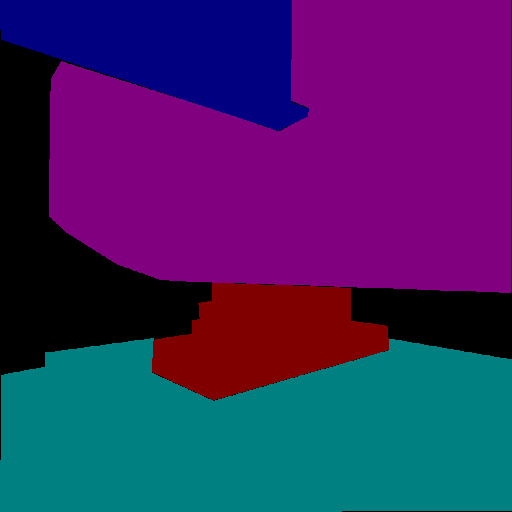

In [4]:
from PIL import Image, ImageDraw
import random
import numpy as np

img_name = '120'
mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/members/conditioning_images/{img_name}.png'
mask_members_np_demo = np.array(Image.open(mask_members_dir))
print(mask_members_np_demo.shape)

random.seed(4)

########### 定义颜色转换方法 ##############
import imgviz

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil

colored_mask(mask_members_np_demo)

[5 6 0 4 1 2 3]
[5, 4, 1, 2, 3]
(512, 512)
P


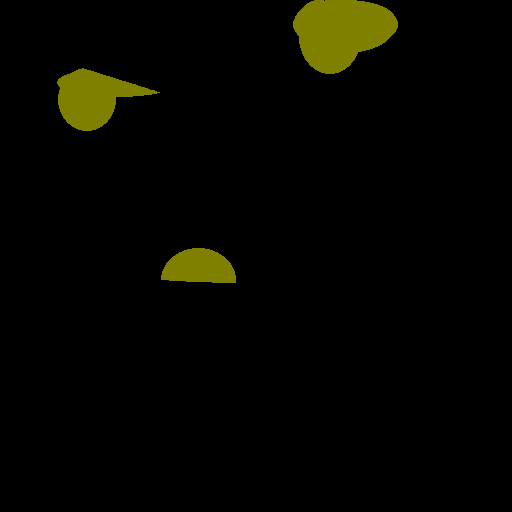

In [5]:
def generate_ellipses(arr, fill_value=3, values=[5], num_ellipses=6, a_min=30, a_max=120, b_min=10, b_max=80, split_everywhere=True, gather_num=2, seed=2024):
    """
    🕐用少数量的大椭圆，模拟大片的腐蚀；
    🕑用多数量的小椭圆，模拟pitting corrosion
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        tuple(numpy.ndarray): A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    # 对图像像素值进行计数统计
    counts = np.bincount(arr.ravel()) 

    # 按像素值从大到小排序
    sorted_indexes = np.argsort(-counts)
    print(sorted_indexes)
    # 过滤0和6
    filtered_indexes = [i for i in sorted_indexes if i not in [0,6]] 
    print(filtered_indexes)


    random.seed(seed)
    np.random.seed(seed)

    for element_type in values:
        if element_type in filtered_indexes:
            selected_region = np.isin(arr, element_type)
            # print(selected_region)
            selected_coords = np.argwhere(selected_region)
            # print(len(selected_coords))


            # # 椭圆数量和范围
            # num_ellipses = 5
            # a_min, a_max = 20, 50
            # b_min, b_max = 10, 30
            
            result = arr.copy()
            image = Image.fromarray(result)
            draw = ImageDraw.Draw(image)
            
            # 空白mask
            result_blank = np.zeros_like(result)
            # print(result_blank)
            image_blank = Image.fromarray(result_blank)
            draw_blank = ImageDraw.Draw(image_blank)
            # # 生成图片
            # im = Image.new('RGB', (100,100), color='white')  
            # draw = ImageDraw.Draw(im)

            if split_everywhere:
                for i in range(num_ellipses):
                    xy_arr = random.sample(list(selected_coords), k=1)
                    # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
                    # print(xy_arr[0][0])
                    y, x = xy_arr[0][0], xy_arr[0][1]
                    # 随机生成长短半轴
                    a = random.randint(a_min, a_max)
                    b = random.randint(b_min, b_max)
                    
                    # 随机中心点
                    # x = random.randint(0, 100-a)
                    # y = random.randint(0, 100-b)
                    
                    # 绘制椭圆
                    draw.ellipse((x, y, x+a, y+b), fill=fill_value)
                    draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
                
                result = np.array(image)
                result_mask = np.array(image_blank)
            elif split_everywhere==False:
                for i in range(gather_num):
                    selected_coords_with_according_to_num_ellipses_list = []
                    xy_arr_0 = random.sample(list(selected_coords), k=1)[0]
                    selected_coords_with_according_to_num_ellipses_list.append(xy_arr_0)
                    count_num = 0
                    for i in list(selected_coords):
                        dist = ((i[0]-xy_arr_0[0])**2 + (i[1]-xy_arr_0[1])**2)**0.5
                        if dist<= (a_max + b_max):
                            selected_coords_with_according_to_num_ellipses_list.append(i)
                            xy_arr_0 = i
                            count_num += 1
                            # print(count_num)
                            # print('a')
                            if count_num == num_ellipses*gather_num:
                                break
                        
                    
                    # selected_coords_with_according_to_num_ellipses_np = np.array(selected_coords_with_according_to_num_ellipses_list)
                    for i in range(num_ellipses):
                        xy_arr = random.sample(selected_coords_with_according_to_num_ellipses_list, k=1)
                        # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
                        # print(xy_arr[0][0])
                        y, x = xy_arr[0][0], xy_arr[0][1]
                        # 随机生成长短半轴
                        a = random.randint(a_min, a_max)
                        b = random.randint(b_min, b_max)
                        
                        # 随机中心点
                        # x = random.randint(0, 100-a)
                        # y = random.randint(0, 100-b)
                        
                        # 绘制椭圆
                        draw.ellipse((x, y, x+a, y+b), fill=fill_value)
                        draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
                    
                    # judge_if_corrosion_in_element(corrosion_arr=)
                    result = np.array(image)
                    result_mask = np.array(image_blank)
                    on_member_num = values[0]
        else: 
            selected_region = np.isin(arr, filtered_indexes[0])   # filtered_indexes[0]是最多的
            # print(selected_region)
            selected_coords = np.argwhere(selected_region)
            # print(len(selected_coords))


            # # 椭圆数量和范围
            # num_ellipses = 5
            # a_min, a_max = 20, 50
            # b_min, b_max = 10, 30
            
            result = arr.copy()
            image = Image.fromarray(result)
            draw = ImageDraw.Draw(image)
            
            # 空白mask
            result_blank = np.zeros_like(result)
            # print(result_blank)
            image_blank = Image.fromarray(result_blank)
            draw_blank = ImageDraw.Draw(image_blank)
            # # 生成图片
            # im = Image.new('RGB', (100,100), color='white')  
            # draw = ImageDraw.Draw(im)

            if split_everywhere:
                for i in range(num_ellipses):
                    xy_arr = random.sample(list(selected_coords), k=1)
                    # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
                    # print(xy_arr[0][0])
                    y, x = xy_arr[0][0], xy_arr[0][1]
                    # 随机生成长短半轴
                    a = random.randint(a_min, a_max)
                    b = random.randint(b_min, b_max)
                    
                    # 随机中心点
                    # x = random.randint(0, 100-a)
                    # y = random.randint(0, 100-b)
                    
                    # 绘制椭圆
                    draw.ellipse((x, y, x+a, y+b), fill=fill_value)
                    draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
                
                result = np.array(image)
                result_mask = np.array(image_blank)
            elif split_everywhere==False:
                for i in range(gather_num):
                    selected_coords_with_according_to_num_ellipses_list = []
                    xy_arr_0 = random.sample(list(selected_coords), k=1)[0]
                    selected_coords_with_according_to_num_ellipses_list.append(xy_arr_0)
                    count_num = 0
                    for i in list(selected_coords):
                        dist = ((i[0]-xy_arr_0[0])**2 + (i[1]-xy_arr_0[1])**2)**0.5
                        if dist<= (a_max + b_max):
                            selected_coords_with_according_to_num_ellipses_list.append(i)
                            xy_arr_0 = i
                            count_num += 1
                            # print(count_num)
                            # print('a')
                            if count_num == num_ellipses*gather_num:
                                break
                        
                    
                    # selected_coords_with_according_to_num_ellipses_np = np.array(selected_coords_with_according_to_num_ellipses_list)
                    for i in range(num_ellipses):
                        xy_arr = random.sample(selected_coords_with_according_to_num_ellipses_list, k=1)
                        # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
                        # print(xy_arr[0][0])
                        y, x = xy_arr[0][0], xy_arr[0][1]
                        # 随机生成长短半轴
                        a = random.randint(a_min, a_max)
                        b = random.randint(b_min, b_max)
                        
                        # 随机中心点
                        # x = random.randint(0, 100-a)
                        # y = random.randint(0, 100-b)
                        
                        # 绘制椭圆
                        draw.ellipse((x, y, x+a, y+b), fill=fill_value)
                        draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
                    
                    # judge_if_corrosion_in_element(corrosion_arr=)
                    result = np.array(image)
                    result_mask = np.array(image_blank)
                    on_member_num = filtered_indexes[0]

            
    
    return result, result_mask, on_member_num

def judge_if_corrosion_in_element(corrosion_arr, element_arr, element_type=5):
    # corrosion_arr = np.array(corrosion_pil)
    # element_arr = np.array(element_pil)
    corrosion_arr_mask = corrosion_arr.copy()

    corrosion_arr_mask = corrosion_arr_mask * (element_arr==element_type)

    return corrosion_arr_mask

result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_demo,num_ellipses=3, split_everywhere=False, gather_num=3)
print(result_e.shape)

filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
print(filted_corrosion_colored_pil.mode)
filted_corrosion_colored_pil

In [6]:
import numpy as np

# 生成一张随机单通道6x6的图像,像素值在0-20范围随机
img = np.random.randint(0, 21, size=(6,6)) 

# 对图像像素值进行计数统计
counts = np.bincount(img.ravel()) 

# 按像素值从大到小排序
sorted_indexes = np.argsort(-counts)

# 输出统计结果
print('Pixel value counts from large to small:')
for i in sorted_indexes:
    print(i, counts[i])
print(sorted_indexes)

Pixel value counts from large to small:
10 4
8 3
0 3
1 3
20 2
4 2
5 2
18 2
7 2
9 2
15 2
17 1
16 1
14 1
3 1
2 1
19 1
6 1
13 1
11 1
12 0
[10  8  0  1 20  4  5 18  7  9 15 17 16 14  3  2 19  6 13 11 12]


## 载入图片

### 用Vit提取embedding的向量作为prompt_embeds，代替text的prompt，

In [10]:
# 设置路径
import os
os.getcwd()
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

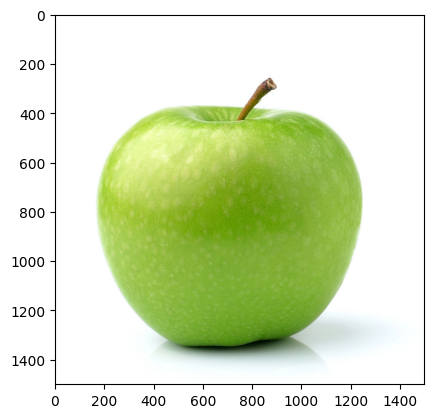

In [15]:
import os
from PIL import Image
from torchvision import transforms
import cv2

from models.modeling import VisionTransformer, CONFIGS

image_name = 'tt_180'
img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion'
image_full_path = os.path.join(img_dir, image_name + '.jpg')

# Prepare ViT Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
# im = Image.open("attention_data/img.jpg")
im = Image.open("attention_data/granny-smith.jpg")
x = transform(im)
plt.imshow(im)

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [13]:
print('model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

feature_map = []
def hook(module, input, output):
    global feature_map
    print(output[0].shape)
    feature_map.append(output[0].detach())
model.transformer.encoder.layer[-1].register_forward_hook(hook)


model parameters: 86567656


In [16]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

Prediction Label and Attention Map!

0.99964 : Granny_Smith
0.00002 : banana
0.00001 : orange
0.00001 : strawberry
0.00001 : lemon


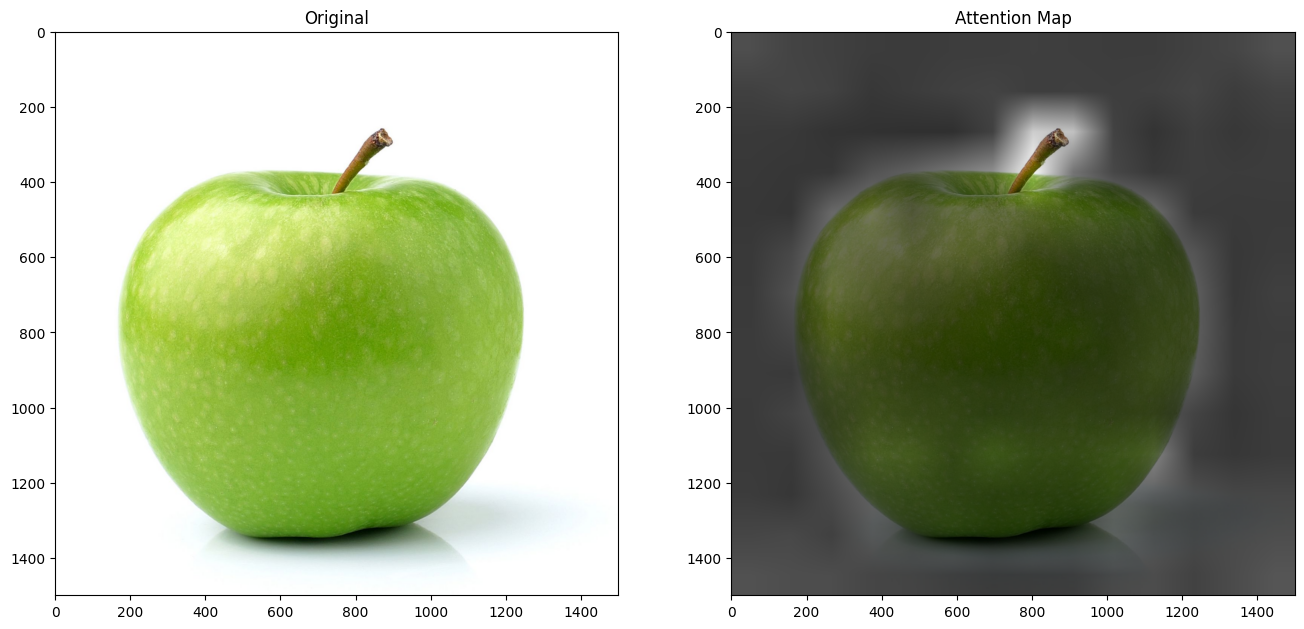

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


[5 6 2 1 4 0 3]
[5, 2, 1, 4, 3]


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:04,  4.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:03,  5.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  5.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:02,  5.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  5.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  5.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:01,  5.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:03<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


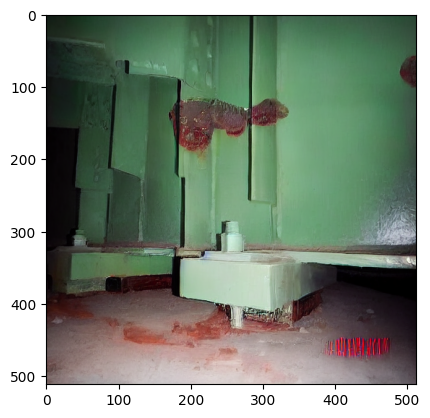

In [11]:
# 单张展示
image_name = 'tt_180' #'373'
prompt = None
prompt = ''

config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'
# control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-256_w-256_2024-07-12_09:10:44_seeds-2024/checkpoint-5700/controlnet'
control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-512_w-512_2024-07-19_11:32:25_seeds-2024/checkpoint-5700/controlnet'

# control_members_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_members_inpainting_h-256_w-256_2024-07-12_14:52:34_seeds-2024/checkpoint-3800/controlnet'
control_members_trained_dir  = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_members_inpainting_h-512_w-512_2024-07-19_15:43:31_seeds-2024/checkpoint-3800/controlnet'

# control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet'

control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_inpainting_h-512_w-512_2024-07-19_21:57:45_seeds-2024/checkpoint-5700/controlnet'
# control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_no_corrosion_inpainting_h-512_w-512_2024-07-20_08:28:10_seeds-2024/checkpoint-2000/controlnet'
# controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth]

import os
img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion'
img_dir_list = os.listdir(img_dir)
save_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/outputs_infered_members_depth_with_org_img_and_gen_corrosion_512_freeu_demo'
os.makedirs(save_dir, exist_ok=True)
# len(img_dir_list)
controlnet_conditioning_scale_list=[3.5,1.0,1.0,1.0] # corrosion, members, depth, org

control_corrosion_dir = control_corrosion_trained_dir
control_members_dir = control_members_trained_dir
# control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_dir = control_depth_trained_dir
print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None')
controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
controlnet_org = ControlNetModel.from_pretrained(control_org_trained_dir)

pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth, controlnet_org]).to(device)
generator = torch.Generator(device=device).manual_seed(seed)
pipeline.unet.use_freeu = True

for img_name in img_dir_list:
    img_name = img_name.split('.')[0]
    if img_name != f'{image_name}':
        continue
    # mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
    mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/output_infer_elements_imgs_ssr101_semi_model/{img_name}.png'
    # mask_members_dir = None
    mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/conditioning_images_with_open_source_no_corrosion_depth/{img_name}.png'
    org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion/{img_name}.jpg'
    if mask_members_dir is not None and org_dir is not None and mask_depth_dir is not None:
        try:

            mask_members_pil = load_image(mask_members_dir)
            mask_members_pil_P = Image.open(mask_members_dir)
            mask_members_np_P = np.array(mask_members_pil_P)
            result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_P, num_ellipses=3, split_everywhere=False, gather_num=3)
            filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
            filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
            filted_corrosion_colored_pil.save(os.path.join(save_dir, f'{img_name}_filted_corrosion.png'))
            
            mask_corrosion_pil = load_image(filted_corrosion_colored_pil)

            mask_depth_pil = load_image(mask_depth_dir)
            org_pil = load_image(org_dir)
            validation_image = [mask_corrosion_pil, mask_members_pil, mask_depth_pil, org_pil]
            image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list
                            ).images[0]
            # image.save(os.path.join(save_dir, f'{img_name}.jpg'))
            plt.imshow(image)
        # else:
        #     print(img_name)
        except Exception as e:
            print(e)
            print('-----Or-----')
            print(f'No image found for {img_name}!')
            pass
        continue
        # plt.figure(figsize=(20, 5))
        # plt.subplot(151)
        # plt.imshow(mask_corrosion_pil)
        # plt.subplot(152)
        # plt.imshow(mask_members_pil)
        # print(mask_members_pil.mode)
        # plt.subplot(153)
        # plt.imshow(mask_depth_pil)
        # print(mask_depth_pil.mode)
        # plt.subplot(154)
        # plt.imshow(org_img_pil)
        # plt.subplot(155)
        # plt.imshow(image)
        # plt.show()
    # 无members，无corrosion，无depth
    else:
        print('Input nothing')
    # image

In [36]:
print(sum(p.numel() for p in pipeline.text_encoder.parameters() if p.requires_grad))
pipeline_text_encoder = pipeline.text_encoder.to(device)
pipeline_tokenizer = pipeline.tokenizer
prompt1 = ""
token1 = pipeline_tokenizer.encode(prompt1, return_tensors='pt').to(device)
print('prompt1 token1:', token1)
out1 = pipeline_text_encoder(token1)
print(out1.keys())
print(out1.last_hidden_state.shape, out1.pooler_output.shape)


123060480
prompt1 token1: tensor([[49406, 49407]], device='cuda:0')
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 2, 768]) torch.Size([1, 768])


In [37]:
# 多张批量保存
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'
# control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-256_w-256_2024-07-12_09:10:44_seeds-2024/checkpoint-5700/controlnet'
control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-512_w-512_2024-07-19_11:32:25_seeds-2024/checkpoint-5700/controlnet'

control_members_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_members_inpainting_h-256_w-256_2024-07-12_14:52:34_seeds-2024/checkpoint-3800/controlnet'
# control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet'

control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_inpainting_h-512_w-512_2024-07-19_21:57:45_seeds-2024/checkpoint-5700/controlnet'
# control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_no_corrosion_inpainting_h-512_w-512_2024-07-20_08:28:10_seeds-2024/checkpoint-2000/controlnet'
# controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth]

import os
img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion'
img_dir_list = os.listdir(img_dir)
save_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/outputs_infered_members_depth_with_org_img_and_gen_corrosion_512_freeu_demo'
os.makedirs(save_dir, exist_ok=True)
# len(img_dir_list)
controlnet_conditioning_scale_list=[3.5,1.0,1.0,1.0]

control_corrosion_dir = control_corrosion_trained_dir
control_members_dir = control_members_trained_dir
# control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_dir = control_depth_trained_dir
print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None')
controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
controlnet_org = ControlNetModel.from_pretrained(control_org_trained_dir)

pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth, controlnet_org]).to(device)
generator = torch.Generator(device=device).manual_seed(seed)
pipeline.unet.use_freeu = True

for img_name in img_dir_list:
    img_name = img_name.split('.')[0]
    # if img_name != '373':
    #     continue
    # mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
    mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/output_infer_elements_imgs_ssr101_semi_model/{img_name}.png'
    # mask_members_dir = None
    mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/conditioning_images_with_open_source_no_corrosion_depth/{img_name}.png'
    org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion/{img_name}.jpg'
    if mask_members_dir is not None and org_dir is not None and mask_depth_dir is not None:
        try:

            mask_members_pil = load_image(mask_members_dir)
            mask_members_pil_P = Image.open(mask_members_dir)
            mask_members_np_P = np.array(mask_members_pil_P)
            result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_P, num_ellipses=3, split_everywhere=False, gather_num=3)
            filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
            filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
            filted_corrosion_colored_pil.save(os.path.join(save_dir, f'{img_name}_filted_corrosion.png'))
            
            mask_corrosion_pil = load_image(filted_corrosion_colored_pil)

            mask_depth_pil = load_image(mask_depth_dir)
            org_pil = load_image(org_dir)
            validation_image = [mask_corrosion_pil, mask_members_pil, mask_depth_pil, org_pil]
            image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list
                            ).images[0]
            image.save(os.path.join(save_dir, f'{img_name}.jpg'))
        # else:
        #     print(img_name)
        except Exception as e:
            print(f'No image found for {img_name}!')
            pass
        continue
        # plt.figure(figsize=(20, 5))
        # plt.subplot(151)
        # plt.imshow(mask_corrosion_pil)
        # plt.subplot(152)
        # plt.imshow(mask_members_pil)
        # print(mask_members_pil.mode)
        # plt.subplot(153)
        # plt.imshow(mask_depth_pil)
        # print(mask_depth_pil.mode)
        # plt.subplot(154)
        # plt.imshow(org_img_pil)
        # plt.subplot(155)
        # plt.imshow(image)
        # plt.show()
    # 无members，无corrosion，无depth
    else:
        print('Input nothing')
    # image

mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


[0 3 5 4 6 2 1]
[3, 5, 4, 2, 1]


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:06,  2.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:04,  4.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:03,  4.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:03,  5.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:01<00:02,  5.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  5.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:01<00:02,  5.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:02,  5.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  5.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  5.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:02<00:01,  5.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:02<00:01,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:01,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  5.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:03<00:00,  5.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:03<00:00,  5.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:03<00:00,  5.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


[6 5 0 2 1 3 4]
[5, 2, 1, 3, 4]


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:06,  2.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:04,  4.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:03,  4.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:03,  5.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:01<00:02,  5.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  5.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:01<00:02,  5.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:02,  5.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  5.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  5.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:02<00:01,  5.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  5.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:02<00:01,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:01,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:03<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:03<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:03<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


[5 2 0 3 6 1 4]
[5, 2, 3, 1, 4]


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:06,  2.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:04,  4.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:03,  4.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:03,  5.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:01<00:02,  5.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  5.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:01<00:02,  5.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:02,  5.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  5.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  5.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:02<00:01,  5.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  5.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:02<00:01,  5.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:01,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:03<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:03<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:03<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


[5 3 2 0 6 1 4]
[5, 3, 2, 1, 4]


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:06,  2.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:04,  4.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:03,  4.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:03,  5.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:01<00:02,  5.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  5.59it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:01<00:02,  5.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:02,  5.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  5.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  5.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:02<00:01,  5.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  5.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:02<00:01,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:01,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  5.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:03<00:00,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:03<00:00,  5.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:03<00:00,  5.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


[5 2 3 0 1 4]
[5, 2, 3, 1, 4]


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:04,  4.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:03,  5.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  5.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:02,  5.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  5.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  5.45it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


KeyboardInterrupt: 

In [18]:
mask_corrosion_np = np.array(mask_corrosion_pil)
mask_corrosion_np.min(), mask_corrosion_np.max(), mask_corrosion_np.shape

(0, 128, (512, 512, 3))

In [ ]:
# if mask_members_dir is not None and mask_corrosion_dir is None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_members_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
#     # Image.show(image)
    
# elif mask_members_dir is  None and mask_corrosion_dir is not None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
# else:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(131)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(132)
#     plt.imshow(mask_members_pil)
#     plt.subplot(133)
#     plt.imshow(image)
#     plt.show()

## PNDM

In [ ]:
# PNDMScheduler
generator = torch.Generator(device=device).manual_seed(seed)
image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## DDPM

In [ ]:
# DDPMScheduler
from diffusers import DDPMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddpm = DDPMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

# print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddpm
# print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

In [ ]:
if mask_members_dir is not None and mask_corrosion_dir is None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_members_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
    # Image.show(image)
    
elif mask_members_dir is  None and mask_corrosion_dir is not None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
else:

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(142)
    plt.imshow(mask_members_pil)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()

## DDIM

In [ ]:
# DDIMScheduler
from diffusers import DDIMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddim = DDIMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddim
print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## PNDM

In [ ]:
# PNDMScheduler
from diffusers import PNDMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_pndm = PNDMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

print(pipeline.scheduler)
pipeline.scheduler = scheduler_pndm
print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

# ***##step by step denoise##***

In [ ]:

control_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_crack_only_generate/checkpoint-2000/controlnet'
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'

## 1.创建各个部分的模型

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, ControlNetModel
import os

vae = AutoencoderKL.from_pretrained(config_dir, subfolder='vae', use_safetensors=None)
tokenizer = CLIPTokenizer.from_pretrained(config_dir, subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained(config_dir, subfolder='text_encoder', use_safetensors=None)
unet = UNet2DConditionModel.from_pretrained(config_dir, subfolder='unet', use_safetensors=None)

controlnet = ControlNetModel.from_pretrained(control_dir)
controlnet.config

In [ ]:
vae.config.scaling_factor

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler_multistep = UniPCMultistepScheduler.from_pretrained(config_dir, subfolder="scheduler")
scheduler_multistep

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
controlnet.to(torch_device)
unet.config

## 2.Create embeddings

### 2.1 Create text embeddings

In [ ]:
prompt = ["crack"]
device = 'cuda'
seed = 0
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=device).manual_seed(seed)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

prompt_embeds = text_embeddings
encoder_hidden_states_control = text_embeddings
text_embeddings.shape

### 2.2 Create image embeddings

In [ ]:
from torchvision import transforms

mask_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/crack（复件）/SegmentationClass/DeepCrack_11240-6.png'
validation_image = Image.open(mask_dir).convert("RGB")
validation_image.size

conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
        ]
    )


conditioning_image_pil = validation_image.resize([512, 512])
conditioning_pixel_values = torch.stack([conditioning_image_transforms(conditioning_image_pil)])
conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()
print(conditioning_pixel_values.shape)
controlnet_image = conditioning_pixel_values.to(torch_device)
# print(controlnet_image)
conditioning_image_pil

In [ ]:
'''
You’ll also need to generate the unconditional text embeddings which are the embeddings for the padding token.
These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:
'''
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings.shape, text_embeddings.shape

In [ ]:
# Let’s concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# text_embeddings
text_embeddings.shape

## 3.Create random noise

In [ ]:
''' 
Next, generate some initial random noise as a starting point for the diffusion process. 
This is the latent representation of the image, and it’ll be gradually denoised. 
At this point, the latent image is smaller than the final image size but that’s okay though 
because the model will transform it into the final 512x512 image dimensions later.
'''

# The height and width are divided by 8 because the vae model has 3 down-sampling layers.
# You can check by running the following:   2 ** (len(vae.config.block_out_channels) - 1) == 8

do_classifier_free_guidance = False
guess_mode = False

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)



latents.shape

In [ ]:
down_block_res_samples, mid_block_res_sample = controlnet(
                    latents,
                    2,
                    encoder_hidden_states=encoder_hidden_states_control,
                    controlnet_cond=controlnet_image,
                    return_dict=False,
                )
len(down_block_res_samples), down_block_res_samples[-1].shape, len(mid_block_res_sample), mid_block_res_sample[0].shape

## 4.Denoise the image

In [ ]:
'''
Start by scaling the input with the initial noise distribution, sigma, the noise scale value, 
which is required for improved schedulers like UniPCMultistepScheduler: 
'''
print(scheduler_multistep.init_noise_sigma)
latents = latents * scheduler_multistep.init_noise_sigma
latents.shape

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler_multistep.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler_multistep.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler_multistep.step(noise_pred, t, latents).prev_sample

In [ ]:
from PIL import Image
from torchvision import transforms

pil_latents = transforms.ToPILImage()(latents.squeeze(0))
pil_latents


## 5.Decode the image

In [ ]:
# scale and decode the image latents with vae
latents_scaled = 1 / vae.config.scaling_factor * latents
# pil_latents_scaled = transforms.ToPILImage()(latents.squeeze(0))
# pil_latents_scaled = transforms.ToPILImage()(latents_scaled.squeeze(0))
with torch.no_grad():
    # image = vae.decode(latents).sample
    image = vae.decode(latents_scaled).sample
print(image.shape)



In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    # expand the latents if we are doing classifier free guidance
    latent_model_input_control = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    # latent_model_input_control = torch.cat([latents_control] * 2)

    latent_model_input_control = scheduler.scale_model_input(latent_model_input_control, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred_control = unet(latent_model_input_control, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond_control, noise_pred_text_control = noise_pred_control.chunk(2)
    noise_pred_control = noise_pred_uncond_control+ guidance_scale * (noise_pred_text_control - noise_pred_uncond_control)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred_control, t, latents).prev_sample

In [ ]:
a = any
a in 'abc'